In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
import seaborn as sns

In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") # this is the same tokenizer that openai uses for their instructGPT model family

In [3]:
path_to_data = "./datasets/kleister_charity/test-A/in.tsv"
path_to_headers = "./datasets/kleister_charity/in-header.tsv"

data = pd.read_csv(path_to_data, sep="\t", header=None)
headers = pd.read_csv(path_to_headers, sep="\t", header=None)
data.columns = headers.iloc[0]
data = data.drop(columns=["text_djvu", "text_tesseract", "text_textract"])

In [4]:
data.head()

,filename,keys,text_best
0,abbf98ed31e28068150dce58296302ee.pdf,address__post_town address__postcode address__...,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...
1,f3e363848aea2fa645814f2de0221a5a.pdf,address__post_town address__postcode address__...,28 November 2015\nHPPC Financial Statements YE...
2,62acdd1bbd0dfeea27da2720eb795449.pdf,address__post_town address__postcode address__...,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...
3,e734bc7dfc9b37c5dd2c3a37693062e8.pdf,address__post_town address__postcode address__...,~e-SCh44\nBreachwood Green PreSchool\nRegister...
4,cb6b0949a2f9294750e436f7ea2f10ce.pdf,address__post_town address__postcode address__...,hahcrar alcrlfcrd haptat church\nBishop's Stor...


In [5]:
len(data)

609

Let's look at the gold keys that we should find in any given document. Although note that some documents don't contain answers to all of the keys, in which case it's correct to simply leave them out.

In [6]:
data.iloc[0]["keys"]

'address__post_town address__postcode address__street_line charity_name charity_number income_annually_in_british_pounds report_date spending_annually_in_british_pounds'

Let's look at how many tokens are in a given document and save it in the dataframe.

In [7]:
data["text_best_number_of_tokens"] = data["text_best"].apply(lambda x: len(tokenizer(x)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (30796 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
data.head()

,filename,keys,text_best,text_best_number_of_tokens
0,abbf98ed31e28068150dce58296302ee.pdf,address__post_town address__postcode address__...,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...,30796
1,f3e363848aea2fa645814f2de0221a5a.pdf,address__post_town address__postcode address__...,28 November 2015\nHPPC Financial Statements YE...,29596
2,62acdd1bbd0dfeea27da2720eb795449.pdf,address__post_town address__postcode address__...,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...,4369
3,e734bc7dfc9b37c5dd2c3a37693062e8.pdf,address__post_town address__postcode address__...,~e-SCh44\nBreachwood Green PreSchool\nRegister...,3016
4,cb6b0949a2f9294750e436f7ea2f10ce.pdf,address__post_town address__postcode address__...,hahcrar alcrlfcrd haptat church\nBishop's Stor...,13639


In [9]:
data["text_best_number_of_tokens"].describe()

count       609.000000
mean      12746.845649
std       19274.031890
min         439.000000
25%        4331.000000
50%        7206.000000
75%       16617.000000
max      294640.000000
Name: text_best_number_of_tokens, dtype: float64

Let's look closer at the distribution of the number of tokens.

294640


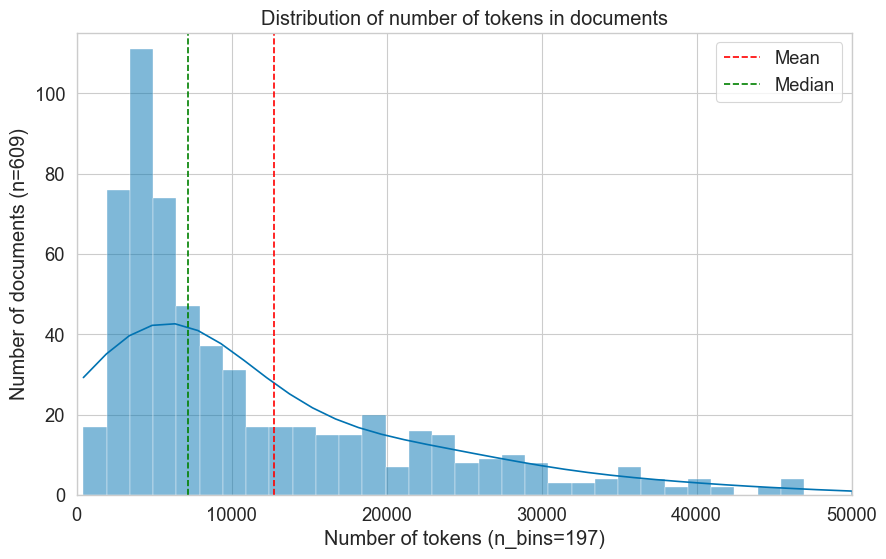

In [27]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x=data["text_best_number_of_tokens"], kde=True, ax=ax, binwidth=1500)
ax.set_title("Distribution of number of tokens in documents")
ax.set_xlabel(f"Number of tokens (n_bins={len(ax.patches)})")
ax.set_ylabel(f"Number of documents (n={len(data)})")
ax.axvline(data["text_best_number_of_tokens"].mean(), color="red", linestyle="--", label="Mean")
ax.axvline(data["text_best_number_of_tokens"].median(), color="green", linestyle="--", label="Median")

ax.legend()
ax.set_xlim(0, 50000)

print(max(data["text_best_number_of_tokens"]))

ax.set_ylim(0, 115)

plt.show()
fig.savefig("plots/token_distribution_zoom_test.png", dpi=300, bbox_inches="tight")

Let's look at the shortest document to get a better idea of what the input text looks like.

In [11]:
shortest = data[data["text_best"].apply(lambda x: len(tokenizer(x)["input_ids"])) == data["text_best_number_of_tokens"].min()]["text_best"].values[0]
shortest

'SWALLOWNEST PLAYGROUP\\nCharity No 1042186\\nANNUAL REPORT 2015-16\\nThis year we have held our level of funds that has allowed\\nschool to continue to deliver a high level of Early Years child\\neducation.\\nThis year we maintained our Quality Mark status.\\nThe staff continued to attend various training courses in\\norder to maintain the high standard of teaching required.\\nThe staff and parent committee were able to secure the\\nfunds to decorate the classroom and the work has been\\ncompleted.\\nThe staff and parent committee continue to work together to\\nobtain funds for teaching and educational resources.\\nWith continued support from parents and the community we\\nwill continue to move forward.\\nIncome Statement for Period\\nEnded August 2015 to July 2016\\nInterest\\n8.86\\nFunding\\n41934.01\\nFees\\n23446.17\\nFees\\nTotal Receipts\\n65389.04\\nRedundancy Provision\\n1300.00\\nCO-OP\\n800.44\\nWages\\n49273.92\\nRoom Hire\\n5265.32\\nPlay Items\\n2651.34\\nPhoto Copying\\

We can see that the text contains double escapes for the newline character, i.e. `\\n` instead of `\n`. This also leads to the fact that the string is not represented correctly when printing it.

In [12]:
shortest = shortest.replace("\\n", "\n")
print(shortest)

SWALLOWNEST PLAYGROUP
Charity No 1042186
ANNUAL REPORT 2015-16
This year we have held our level of funds that has allowed
school to continue to deliver a high level of Early Years child
education.
This year we maintained our Quality Mark status.
The staff continued to attend various training courses in
order to maintain the high standard of teaching required.
The staff and parent committee were able to secure the
funds to decorate the classroom and the work has been
completed.
The staff and parent committee continue to work together to
obtain funds for teaching and educational resources.
With continued support from parents and the community we
will continue to move forward.
Income Statement for Period
Ended August 2015 to July 2016
Interest
8.86
Funding
41934.01
Fees
23446.17
Fees
Total Receipts
65389.04
Redundancy Provision
1300.00
CO-OP
800.44
Wages
49273.92
Room Hire
5265.32
Play Items
2651.34
Photo Copying
216.00
Petty Cash
120.00
Equipment
349.00
Postage
1895.05
Misc
622.80
Cleani

This looks much better. Let's do it for all rows and also for other control characters. Let's also remove redundant spaces.

In [13]:
data["text_best_cleaned"] = data["text_best"].apply(lambda x: x.replace("\\n", "\n").replace("\\t", "\t").replace("\\r", "\r").replace("\\", "").replace("  ", " "))

Let's also save the number of tokens of the cleaned text.

In [14]:
data["text_best_cleaned_number_of_tokens"] = data["text_best_cleaned"].apply(lambda x: len(tokenizer(x)["input_ids"]))

In [15]:
data.head()

,filename,keys,text_best,text_best_number_of_tokens,text_best_cleaned,text_best_cleaned_number_of_tokens
0,abbf98ed31e28068150dce58296302ee.pdf,address__post_town address__postcode address__...,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...,30796,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...,28003
1,f3e363848aea2fa645814f2de0221a5a.pdf,address__post_town address__postcode address__...,28 November 2015\nHPPC Financial Statements YE...,29596,28 November 2015\nHPPC Financial Statements YE...,27039
2,62acdd1bbd0dfeea27da2720eb795449.pdf,address__post_town address__postcode address__...,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...,4369,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...,3582
3,e734bc7dfc9b37c5dd2c3a37693062e8.pdf,address__post_town address__postcode address__...,~e-SCh44\nBreachwood Green PreSchool\nRegister...,3016,~e-SCh44\nBreachwood Green PreSchool\nRegister...,2720
4,cb6b0949a2f9294750e436f7ea2f10ce.pdf,address__post_town address__postcode address__...,hahcrar alcrlfcrd haptat church\nBishop's Stor...,13639,hahcrar alcrlfcrd haptat church\nBishop's Stor...,12218


In [16]:
print(f"Total number of tokens before cleaning: {data['text_best_number_of_tokens'].sum()}")
print(f"Total number of tokens after cleaning: {data['text_best_cleaned_number_of_tokens'].sum()}")

print(f"Percent of tokens that were removed: {100 - (data['text_best_cleaned_number_of_tokens'].sum() / data['text_best_number_of_tokens'].sum()) * 100}")

Total number of tokens before cleaning: 7762829
Total number of tokens after cleaning: 6991262
Percent of tokens that were removed: 9.939250239828795


Let's see how many documents still have a length longer than 4000 tokens after cleaning, which is the maximum number of tokens that the Davinci model from OpenAI can handle as input. Note that there are 609 documents in total.

In [17]:
len(data[data["text_best_cleaned_number_of_tokens"] > 4000])

444

The situation looks even more dire when considering the limitation of GPT-NeoX which has a context length of 2048, meaning the total number of tokens (prompt + generated text) cannot exceed 2048. Assuming we keep about 148 tokens for the output, let's find how many documents are longer than 1900 tokens.

In [18]:
len(data[data["text_best_cleaned_number_of_tokens"] > 1900])

588

In [19]:
data.head()

,filename,keys,text_best,text_best_number_of_tokens,text_best_cleaned,text_best_cleaned_number_of_tokens
0,abbf98ed31e28068150dce58296302ee.pdf,address__post_town address__postcode address__...,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...,30796,PRAESTAT OPES SAPIENTIA\nHAMPTON SCHOOL\n(A Ch...,28003
1,f3e363848aea2fa645814f2de0221a5a.pdf,address__post_town address__postcode address__...,28 November 2015\nHPPC Financial Statements YE...,29596,28 November 2015\nHPPC Financial Statements YE...,27039
2,62acdd1bbd0dfeea27da2720eb795449.pdf,address__post_town address__postcode address__...,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...,4369,1\nIER\nMarch 2012\nIndependent Examiner’s\nRe...,3582
3,e734bc7dfc9b37c5dd2c3a37693062e8.pdf,address__post_town address__postcode address__...,~e-SCh44\nBreachwood Green PreSchool\nRegister...,3016,~e-SCh44\nBreachwood Green PreSchool\nRegister...,2720
4,cb6b0949a2f9294750e436f7ea2f10ce.pdf,address__post_town address__postcode address__...,hahcrar alcrlfcrd haptat church\nBishop's Stor...,13639,hahcrar alcrlfcrd haptat church\nBishop's Stor...,12218


In [20]:
data.to_csv("./datasets/kleister_charity/test-A/in_extended.tsv", sep="\t", index=False)

In [21]:
# sort data by text_best_cleaned_number_of_tokens (ascending)
data = data.sort_values(by="text_best_cleaned_number_of_tokens", ascending=True)
data.head()

,filename,keys,text_best,text_best_number_of_tokens,text_best_cleaned,text_best_cleaned_number_of_tokens
390,b6b29176dc874f9d27e8746d51fcf8cb.pdf,address__post_town address__postcode address__...,SWALLOWNEST PLAYGROUP\nCharity No 1042186\nANN...,439,SWALLOWNEST PLAYGROUP\nCharity No 1042186\nANN...,375
260,6f6455ca99e1b5fa504f57b211b6fd1e.pdf,address__post_town address__postcode address__...,Swallownest Pre School (Playgroup)\nAnnual Rep...,500,Swallownest Pre School (Playgroup)\nAnnual Rep...,437
317,2a794c6d00c8b73f86a1ae30854f1452.pdf,address__post_town address__postcode address__...,Ghousia Mehra Trust of Harlow\nCharity number:...,1050,Ghousia Mehra Trust of Harlow\nCharity number:...,949
311,2674cf593545bd61ab2bc4aeca8a5021.pdf,address__post_town address__postcode address__...,"£\n£\nFee Income\n53,751 .89\nSalaries\n32,290...",1194,"£\n£\nFee Income\n53,751 .89\nSalaries\n32,290...",1068
209,371ca8f29a40f220bd84326dec803b9f.pdf,address__post_town address__postcode address__...,WILD ACRE RESCUE\nRegistered Charity No 115331...,1248,WILD ACRE RESCUE\nRegistered Charity No 115331...,1122


In [22]:
# get text_best_cleaned of the shortest document (without gold annotation errors)
shortest = data.iloc[0]["text_best_cleaned"]
print(shortest)

SWALLOWNEST PLAYGROUP
Charity No 1042186
ANNUAL REPORT 2015-16
This year we have held our level of funds that has allowed
school to continue to deliver a high level of Early Years child
education.
This year we maintained our Quality Mark status.
The staff continued to attend various training courses in
order to maintain the high standard of teaching required.
The staff and parent committee were able to secure the
funds to decorate the classroom and the work has been
completed.
The staff and parent committee continue to work together to
obtain funds for teaching and educational resources.
With continued support from parents and the community we
will continue to move forward.
Income Statement for Period
Ended August 2015 to July 2016
Interest
8.86
Funding
41934.01
Fees
23446.17
Fees
Total Receipts
65389.04
Redundancy Provision
1300.00
CO-OP
800.44
Wages
49273.92
Room Hire
5265.32
Play Items
2651.34
Photo Copying
216.00
Petty Cash
120.00
Equipment
349.00
Postage
1895.05
Misc
622.80
Cleani